In [34]:
# import necessary libraries
import pandas as pd 
import numpy as np
import pickle
import torch
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow import keras
import random
import keras_tuner as kt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [35]:
# load data
path = "datasets/CNAP_blood_pressure.csv"

df = pd.read_csv(path)
df.head()

,ecg_0,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,...,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,SBP,DBP,subject,trial
0,-784.0,-754.0,-732.0,-715.0,-689.0,-671.0,-658.0,-646.0,-638.0,-637.0,...,56603.0,56608.0,56612.0,56581.0,56551.0,56557.0,131.607056,58.044434,0,1.0
1,686.0,680.0,298.0,-294.0,-688.0,-596.0,-101.0,442.0,717.0,715.0,...,56247.0,56227.0,56203.0,56213.0,56224.0,56207.0,131.607056,58.044434,0,1.0
2,590.0,560.0,107.0,-534.0,-871.0,-632.0,-32.0,511.0,748.0,740.0,...,56374.0,56364.0,56351.0,56373.0,56399.0,56397.0,127.789307,57.366943,0,1.0
3,633.0,582.0,164.0,-412.0,-729.0,-529.0,17.0,523.0,724.0,691.0,...,56939.0,56922.0,56904.0,56922.0,56942.0,56930.0,128.906250,55.453491,0,1.0
4,694.0,424.0,-138.0,-671.0,-805.0,-463.0,119.0,573.0,695.0,653.0,...,56378.0,56367.0,56388.0,56408.0,56394.0,56378.0,125.912476,55.142212,0,1.0


In [36]:
df.describe()

,ecg_0,ecg_1,ecg_2,ecg_3,ecg_4,ecg_5,ecg_6,ecg_7,ecg_8,ecg_9,...,ppg_94,ppg_95,ppg_96,ppg_97,ppg_98,ppg_99,SBP,DBP,subject,trial
count,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,...,16047.00000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000,16047.000000
mean,1066.188945,431.663613,-1184.575871,-2584.160404,-2717.941609,-1756.763881,-644.251387,52.182402,383.462890,527.773914,...,43437.17536,43437.930953,43438.393968,43438.538605,43438.402817,43438.024553,123.233116,65.425236,3.436219,2.504393
std,596.022072,535.347140,1113.145288,1764.257444,1902.970274,1624.898566,1101.846380,532.029296,249.209632,288.587199,...,18823.48963,18824.907741,18826.414014,18827.809178,18828.936537,18829.911345,17.885018,12.599646,2.226186,1.117698
min,-5336.000000,-3104.000000,-5561.000000,-8135.000000,-8159.000000,-7152.000000,-4674.000000,-2434.000000,-1592.000000,-1497.000000,...,19505.00000,19481.000000,19474.000000,19463.000000,19443.000000,19433.000000,72.106934,27.767944,0.000000,1.000000
25%,641.000000,143.000000,-1963.500000,-3912.500000,-4168.500000,-2798.500000,-1271.500000,-216.000000,226.000000,323.000000,...,27992.50000,27994.500000,27999.500000,27995.000000,27992.500000,27983.000000,111.749268,56.675720,2.000000,2.000000
50%,780.000000,418.000000,-931.000000,-2302.000000,-2233.000000,-1286.000000,-169.000000,157.000000,344.000000,491.000000,...,35665.00000,35665.000000,35669.000000,35671.000000,35664.000000,35662.000000,123.074341,64.022827,3.000000,3.000000
75%,1637.500000,656.000000,-244.000000,-1088.500000,-1337.500000,-460.500000,129.000000,391.000000,499.000000,716.000000,...,59455.50000,59460.000000,59467.000000,59476.000000,59479.000000,59481.000000,133.680725,73.104858,5.000000,4.000000
max,4394.000000,3014.000000,1375.000000,946.000000,838.000000,1112.000000,2779.000000,2688.000000,2597.000000,2754.000000,...,83872.00000,83911.000000,83950.000000,83938.000000,83925.000000,83961.000000,191.830444,123.944092,7.000000,4.000000


In [37]:
# x y split
feature_cols = df.columns[:300]
target_cols = ['SBP', 'DBP']
groups = df['subject'].values

X = df[feature_cols].values
y = df[target_cols].values

In [38]:
groups.shape

(16047,)

In [39]:
# apply MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)
X = scaler_x.fit_transform(X)

In [40]:
# reshape to (samples, timesteps, features)
X = X.reshape((-1, 3, 100))
X = np.transpose(X, (0, 2, 1))
X.shape, y.shape

((16047, 100, 3), (16047, 2))

In [41]:
def plot_predictions(test_prediction, y_test):
    """
    Plot the features of a sample.
    """

    test_dict = {
        "Systolic": y_test[:, 0],
        "Diastolic": y_test[:, 1],
    }

    prediction_dict = {
        "Systolic": test_prediction[:, 0],
        "Diastolic": test_prediction[:, 1],
    }

    test_df = pd.DataFrame(test_dict)
    prediction_df = pd.DataFrame(prediction_dict)


    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

    axs[0].plot(test_df["Systolic"], color='blue')
    axs[0].plot(prediction_df["Systolic"], color='#1f77b4')
    axs[0].set_title("Systolic")
    axs[0].grid(True)

    axs[1].plot(test_df["Diastolic"], color='green')
    axs[1].plot(prediction_df["Diastolic"], color='#2ca02c')
    axs[1].set_title("Diastolic")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [42]:
param_grid = {
        'CLASSIFICADOR': 'LSTM',
        'RECURRENT_LAYERS': (64, 32),
        'DENSE_LAYERS': (32,),
        'BATCH_SIZE': 32,
        'LEARNING_RATE': 0.001,
        'EPOCHS': 25,
        'ACTIVATION': 'tanh',
        'OPTIMIZER': 'adam'
    }

In [43]:
logo = LeaveOneGroupOut()

Train shape: (14243, 100, 3), Test shape: (1804, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0174 - mae: 0.1028 - mean_absolute_percentage_error: 27424.6113 - val_loss: 0.0473 - val_mae: 0.1835 - val_mean_absolute_percentage_error: 35.4302
Epoch 2/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0154 - mae: 0.0974 - mean_absolute_percentage_error: 26798.3203 - val_loss: 0.0440 - val_mae: 0.1782 - val_mean_absolute_percentage_error: 35.3634
Epoch 3/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0128 - mae: 0.0891 - mean_absolute_percentage_error: 28016.1211 - val_loss: 0.0786 - val_mae: 0.2343 - val_mean_absolute_percentage_error: 42.9978
Epoch 4/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0106 - mae: 0.0806 - mean_absolute_percentage_error: 24875.4531 - val_loss: 0.0766 - val_mae: 0.2324 - val_mean_absolute_percentage_error: 42.5224
Epoch 5/25
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0091 - mae: 0.0746 - mean_absolute_percentage_error: 28811.8203 - val_loss: 0.0853 - val_mae

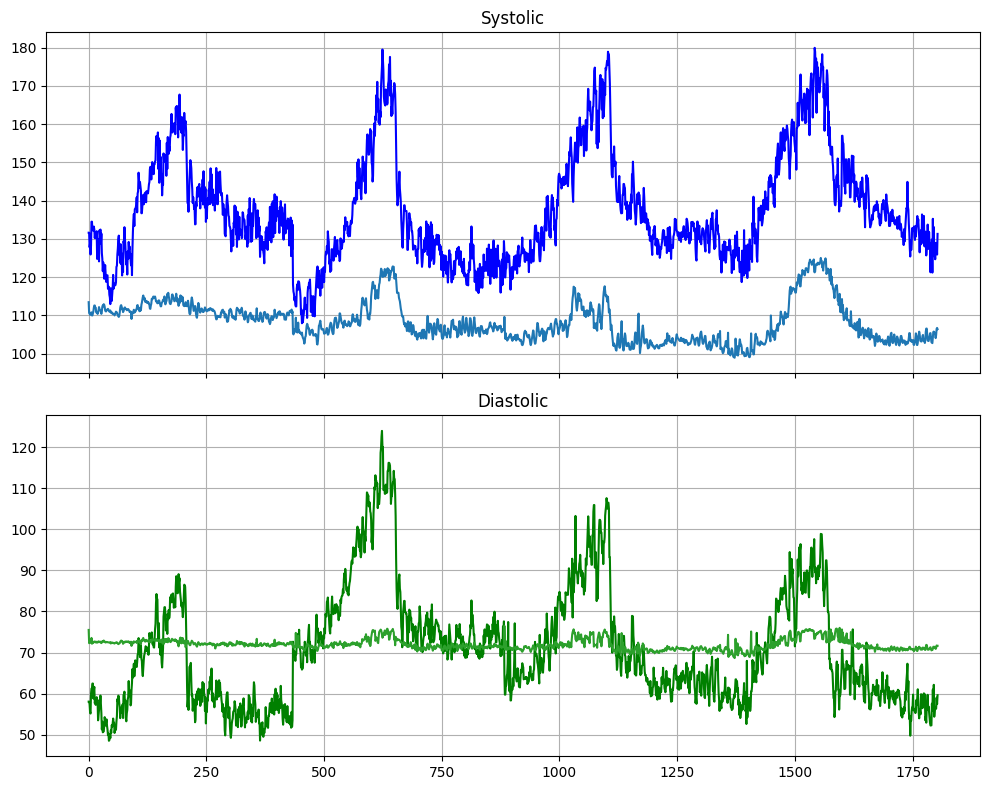

Train shape: (13847, 100, 3), Test shape: (2200, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0172 - mae: 0.1024 - mean_absolute_percentage_error: 28343.9863 - val_loss: 0.0260 - val_mae: 0.1327 - val_mean_absolute_percentage_error: 46.8424
Epoch 2/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0142 - mae: 0.0939 - mean_absolute_percentage_error: 28766.4727 - val_loss: 0.0354 - val_mae: 0.1566 - val_mean_absolute_percentage_error: 56.5929
Epoch 3/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0132 - mae: 0.0908 - mean_absolute_percentage_error: 28251.7266 - val_loss: 0.0662 - val_mae: 0.2220 - val_mean_absolute_percentage_error: 79.3794
Epoch 4/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0123 - mae: 0.0881 - mean_absolute_percentage_error: 26481.8574 - val_loss: 0.1083 - val_mae: 0.2928 - val_mean_absolute_percentage_error: 102.7198
Epoch 5/25
433/433 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0114 - mae: 0.0842 - mean_absolute_percentage_error: 26775.7559 - val_loss: 0.1086 - val_ma

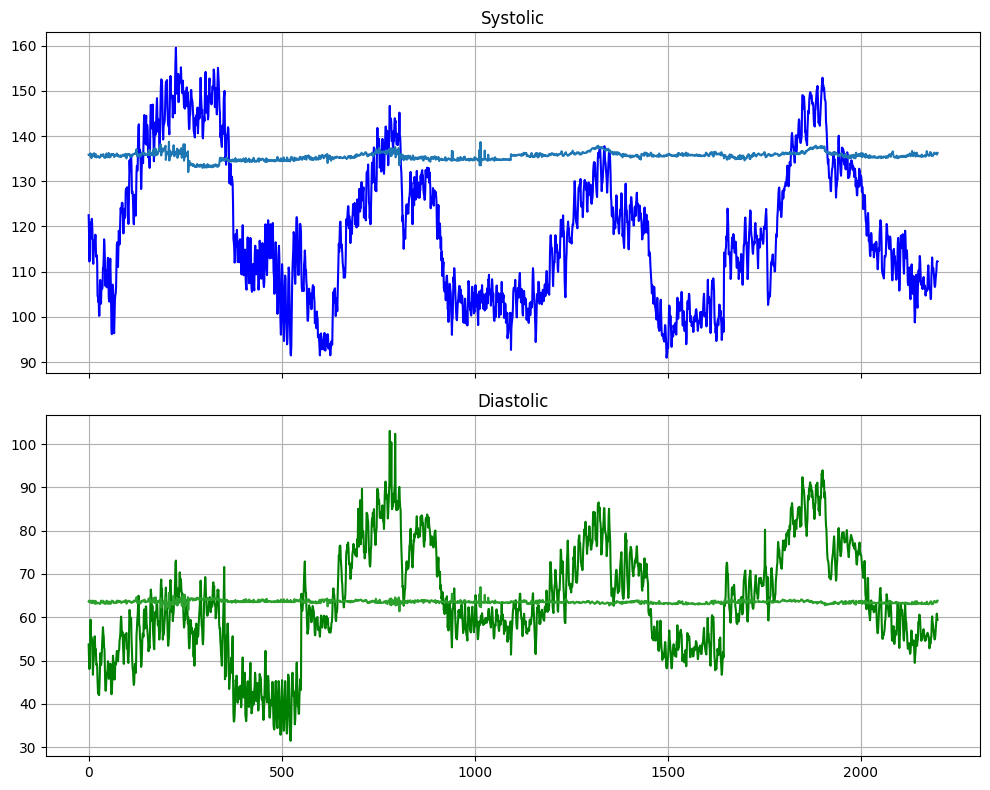

Train shape: (14100, 100, 3), Test shape: (1947, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0186 - mae: 0.1062 - mean_absolute_percentage_error: 30058.9453 - val_loss: 0.0265 - val_mae: 0.1330 - val_mean_absolute_percentage_error: 29.8228
Epoch 2/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0159 - mae: 0.0993 - mean_absolute_percentage_error: 29162.1465 - val_loss: 0.0246 - val_mae: 0.1271 - val_mean_absolute_percentage_error: 28.8414
Epoch 3/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0144 - mae: 0.0957 - mean_absolute_percentage_error: 27692.3398 - val_loss: 0.0282 - val_mae: 0.1395 - val_mean_absolute_percentage_error: 31.9351
Epoch 4/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0126 - mae: 0.0896 - mean_absolute_percentage_error: 29103.2266 - val_loss: 0.0332 - val_mae: 0.1540 - val_mean_absolute_percentage_error: 35.0225
Epoch 5/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0107 - mae: 0.0820 - mean_absolute_percentage_error: 26446.0723 - val_loss: 0.0313 - val_mae

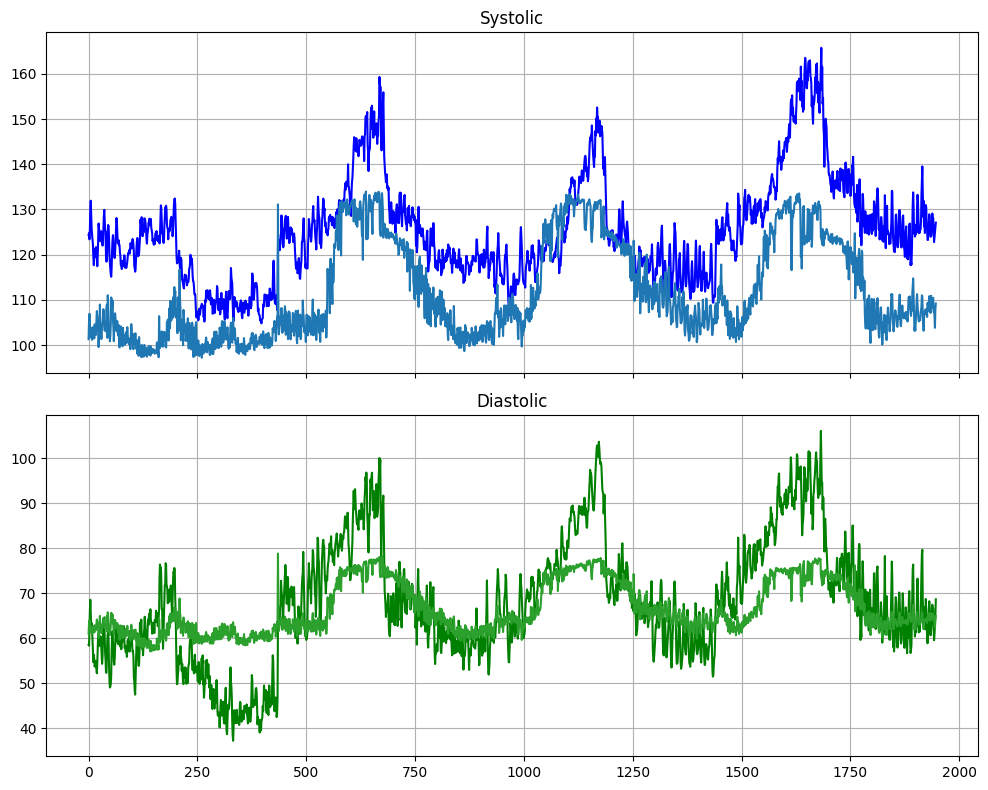

Train shape: (13681, 100, 3), Test shape: (2366, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0173 - mae: 0.1036 - mean_absolute_percentage_error: 28744.6035 - val_loss: 0.0292 - val_mae: 0.1378 - val_mean_absolute_percentage_error: 38.2747
Epoch 2/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0143 - mae: 0.0958 - mean_absolute_percentage_error: 27486.4512 - val_loss: 0.0339 - val_mae: 0.1457 - val_mean_absolute_percentage_error: 40.1709
Epoch 3/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0137 - mae: 0.0936 - mean_absolute_percentage_error: 28344.8594 - val_loss: 0.0317 - val_mae: 0.1397 - val_mean_absolute_percentage_error: 37.8515
Epoch 4/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0135 - mae: 0.0928 - mean_absolute_percentage_error: 28131.9707 - val_loss: 0.0327 - val_mae: 0.1387 - val_mean_absolute_percentage_error: 35.5131
Epoch 5/25
428/428 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0130 - mae: 0.0908 - mean_absolute_percentage_error: 29149.5449 - val_loss: 0.0346 - val_mae

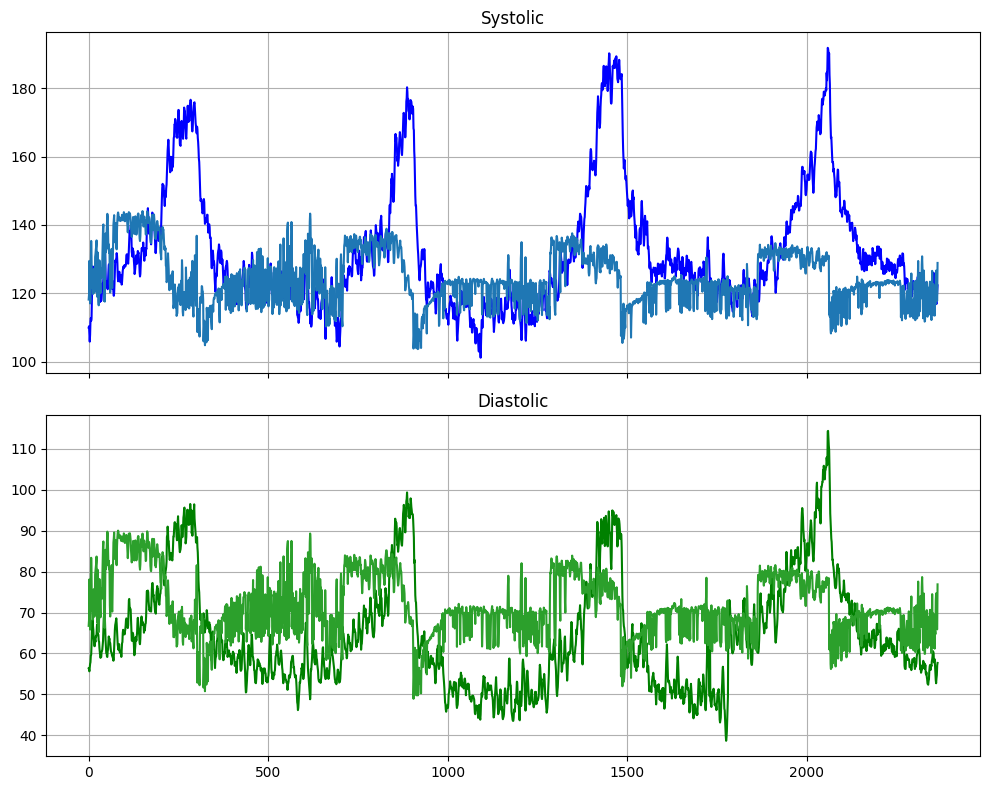

Train shape: (13894, 100, 3), Test shape: (2153, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0194 - mae: 0.1075 - mean_absolute_percentage_error: 27600.1953 - val_loss: 0.0156 - val_mae: 0.1007 - val_mean_absolute_percentage_error: 22.2440
Epoch 2/25
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0161 - mae: 0.0997 - mean_absolute_percentage_error: 25095.0645 - val_loss: 0.0166 - val_mae: 0.1042 - val_mean_absolute_percentage_error: 22.9399
Epoch 3/25
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0151 - mae: 0.0968 - mean_absolute_percentage_error: 25316.7461 - val_loss: 0.0189 - val_mae: 0.1124 - val_mean_absolute_percentage_error: 24.3764
Epoch 4/25
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0138 - mae: 0.0928 - mean_absolute_percentage_error: 30484.5801 - val_loss: 0.0274 - val_mae: 0.1375 - val_mean_absolute_percentage_error: 31.5340
Epoch 5/25
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0115 - mae: 0.0846 - mean_absolute_percentage_error: 28390.0176 - val_loss: 0.0289 - val_mae

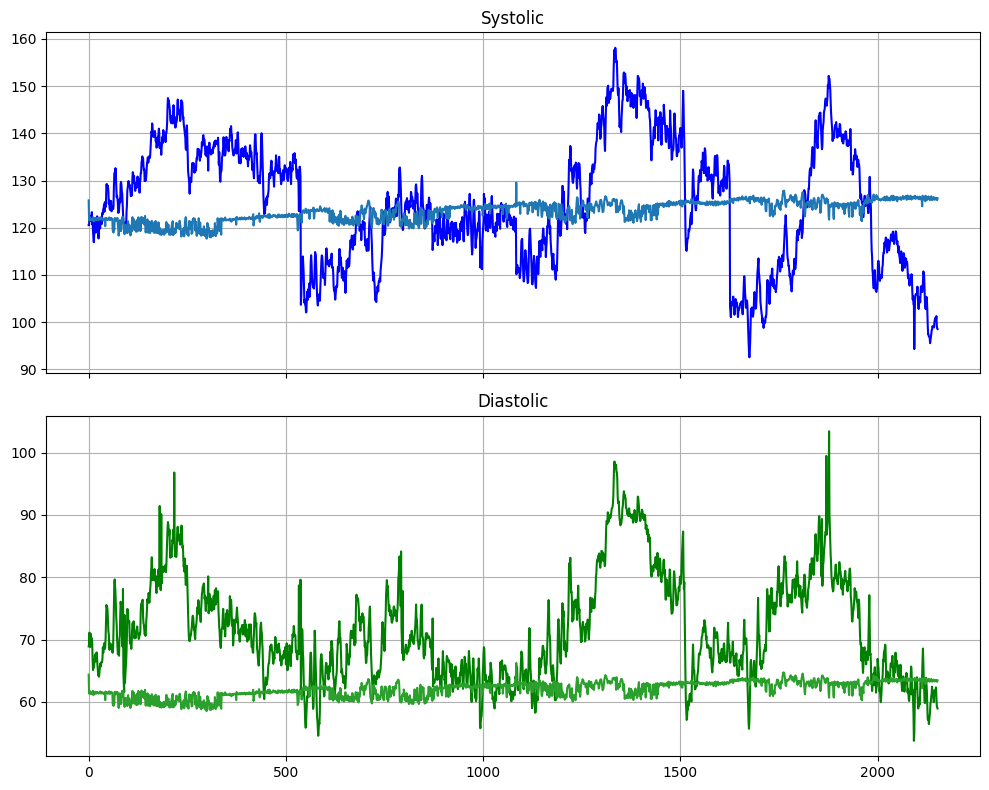

Train shape: (13986, 100, 3), Test shape: (2061, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0180 - mae: 0.1046 - mean_absolute_percentage_error: 26661.5078 - val_loss: 0.0270 - val_mae: 0.1342 - val_mean_absolute_percentage_error: 71.1512
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0163 - mae: 0.1006 - mean_absolute_percentage_error: 25088.0508 - val_loss: 0.0253 - val_mae: 0.1309 - val_mean_absolute_percentage_error: 66.6025
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0134 - mae: 0.0916 - mean_absolute_percentage_error: 29826.0371 - val_loss: 0.0258 - val_mae: 0.1294 - val_mean_absolute_percentage_error: 68.7513
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0108 - mae: 0.0819 - mean_absolute_percentage_error: 27406.0664 - val_loss: 0.0229 - val_mae: 0.1208 - val_mean_absolute_percentage_error: 64.0231
Epoch 5/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0100 - mae: 0.0788 - mean_absolute_percentage_error: 28893.3262 - val_loss: 0.0294 - val_mae

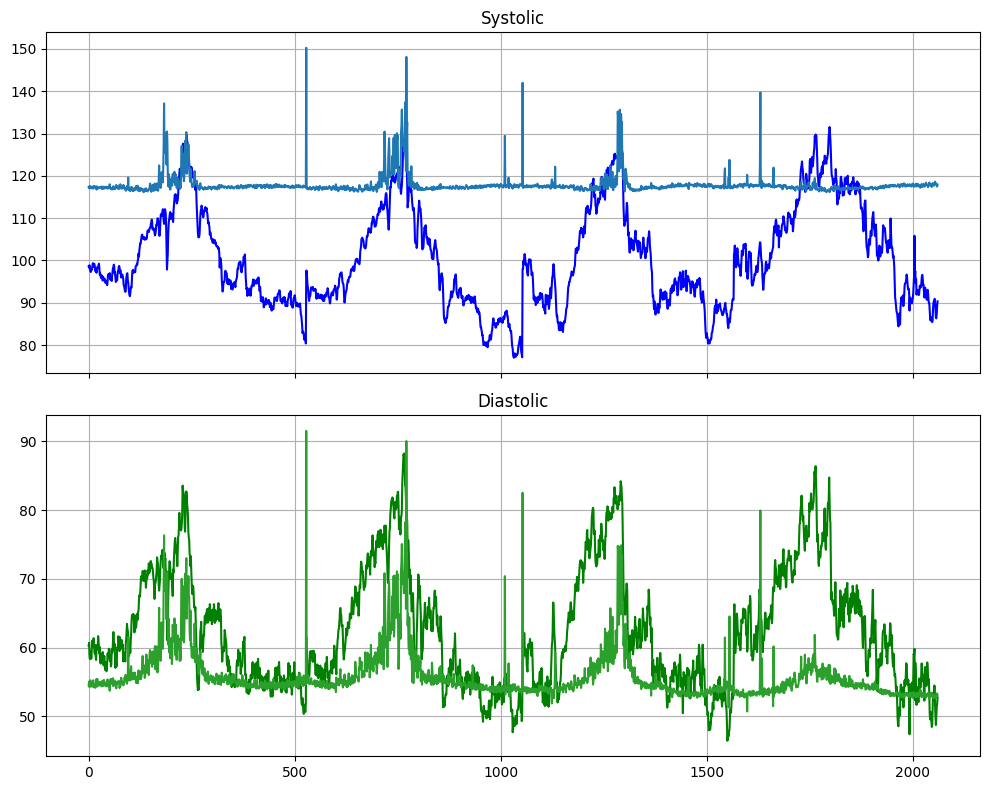

Train shape: (14467, 100, 3), Test shape: (1580, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
453/453 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0177 - mae: 0.1035 - mean_absolute_percentage_error: 27323.6465 - val_loss: 0.0183 - val_mae: 0.1099 - val_mean_absolute_percentage_error: 27.8652
Epoch 2/25
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0153 - mae: 0.0976 - mean_absolute_percentage_error: 27480.7383 - val_loss: 0.0197 - val_mae: 0.1138 - val_mean_absolute_percentage_error: 28.7705
Epoch 3/25
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0140 - mae: 0.0935 - mean_absolute_percentage_error: 29382.4961 - val_loss: 0.0164 - val_mae: 0.1000 - val_mean_absolute_percentage_error: 25.0799
Epoch 4/25
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0118 - mae: 0.0860 - mean_absolute_percentage_error: 26245.1582 - val_loss: 0.0147 - val_mae: 0.0936 - val_mean_absolute_percentage_error: 24.0413
Epoch 5/25
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0099 - mae: 0.0782 - mean_absolute_percentage_error: 27700.3633 - val_loss: 0.0139 - val_mae

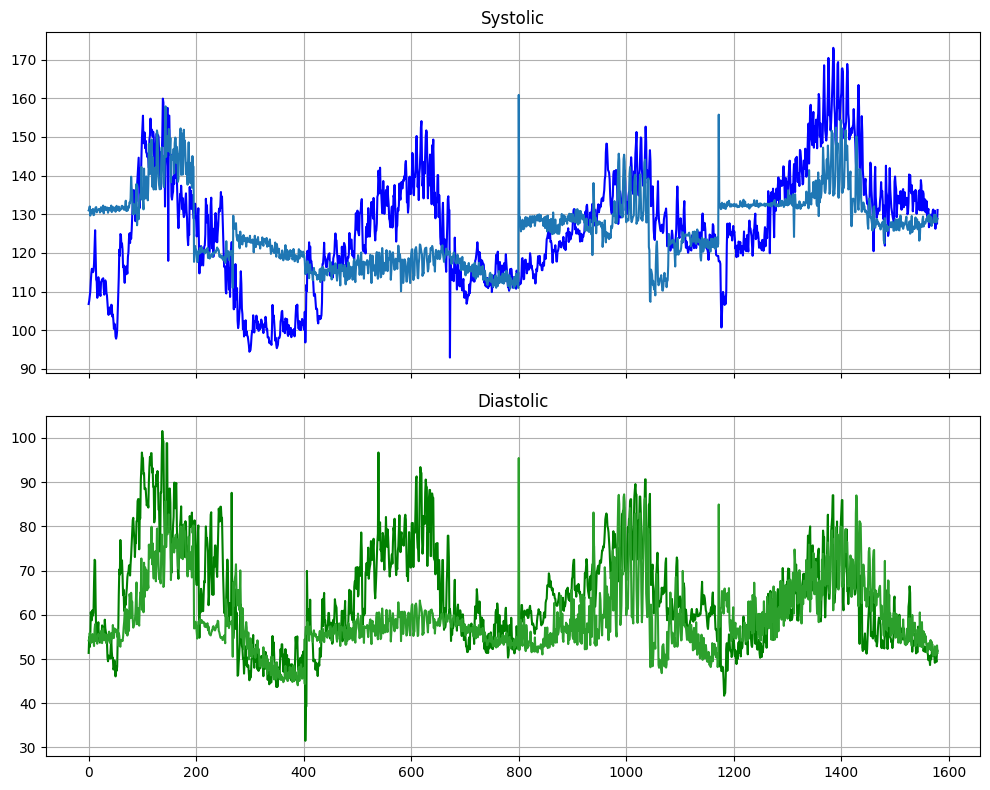

Train shape: (14111, 100, 3), Test shape: (1936, 100, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,946 (120.88 KB)

 Trainable params: 30,946 (120.88 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0174 - mae: 0.1022 - mean_absolute_percentage_error: 29.3982 - val_loss: 0.0276 - val_mae: 0.1366 - val_mean_absolute_percentage_error: 222077.2344
Epoch 2/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0145 - mae: 0.0946 - mean_absolute_percentage_error: 26.9001 - val_loss: 0.0238 - val_mae: 0.1280 - val_mean_absolute_percentage_error: 211360.2344
Epoch 3/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0114 - mae: 0.0842 - mean_absolute_percentage_error: 23.9070 - val_loss: 0.0210 - val_mae: 0.1207 - val_mean_absolute_percentage_error: 212379.9531
Epoch 4/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0092 - mae: 0.0750 - mean_absolute_percentage_error: 21.1799 - val_loss: 0.0204 - val_mae: 0.1179 - val_mean_absolute_percentage_error: 211336.6562
Epoch 5/25
441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0082 - mae: 0.0707 - mean_absolute_percentage_error: 19.9039 - val_loss: 0.0196 - val_ma

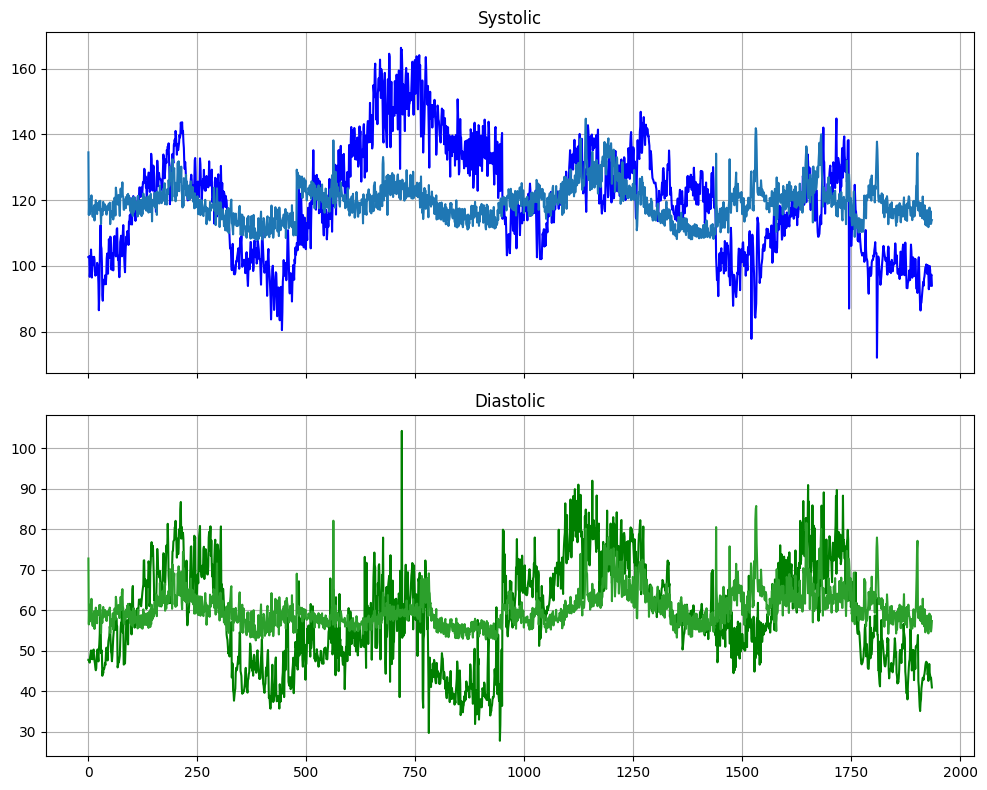

In [44]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


for train_idx, test_idx in logo.split(X, y, groups=groups):
    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    print(f'Train shape: {X_train.shape}, Test shape: {X_val.shape}')

    # define the model
    model = Sequential([
        Input(shape=(100, 3)),
        LSTM(param_grid['RECURRENT_LAYERS'][0], activation=param_grid['ACTIVATION'], return_sequences=True),
        LSTM(param_grid['RECURRENT_LAYERS'][1], activation=param_grid['ACTIVATION']),
        Dense(param_grid['DENSE_LAYERS'][0], activation='relu'),
        Dense(2, activation='linear')
    ])
    
    # Choose optimizer with learning rate
    if param_grid['OPTIMIZER'] == 'adam':
        optimizer = Adam(learning_rate=param_grid['LEARNING_RATE'])
    elif param_grid['OPTIMIZER'] == 'sgd':
        optimizer = SGD(learning_rate=param_grid['LEARNING_RATE'])

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', tf.keras.metrics.MeanAbsolutePercentageError()])
    print(model.summary())
    
    # early stopping callback
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        patience = 5,
        restore_best_weights = True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=param_grid['EPOCHS'],
        batch_size=param_grid['BATCH_SIZE'],
        callbacks=[early_stop]
    )
    
    # Rescale predictions back to original scale
    y_pred = model.predict(X_val)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)
    y_val_rescaled = scaler_y.inverse_transform(y_val)

    # Evaluate on the original scale
    mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
    mape = mean_absolute_percentage_error(y_val_rescaled, y_pred_rescaled)
    loss = mean_squared_error(y_val_rescaled, y_pred_rescaled)
    
    print(f'Test Loss: {loss:.4f} - Test MAE: {mae:.4f} - Test MAPE: {mape:.4f}')

    # plot predictions
    plot_predictions(y_pred_rescaled, y_val_rescaled)

    # clear memory
    del model
    tf.keras.backend.clear_session()
